In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


C:\Users\AylinGülüm\AppData\Local\Temp\ipykernel_16400\1621238366.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 432x288 with 0 Axes>

# Loading the data

In [2]:
# Cargar el dataset
df = pd.read_csv('twits_25k_balanced.csv')  # Reemplaza 'tu_archivo.csv' con el nombre de tu archivo

In [3]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Correct import statement
from tensorflow.keras.utils import to_categorical

In [4]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Initialize the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Tokenize and pad the input sequences
def tokenize_roberta(data, max_len=128):
    input_ids = []
    attention_masks = []
    for text in data['tweet']:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,  # Add truncation to handle longer sequences
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'  # Use 'tf' to get TensorFlow tensors
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.vstack(input_ids), np.vstack(attention_masks)

# Tokenize the training and testing data
train_input_ids, train_attention_masks = tokenize_roberta(train_data)
test_input_ids, test_attention_masks = tokenize_roberta(test_data)

# Convert labels to one-hot encoded format
y_train = to_categorical(train_data['label'], num_classes=3)
y_test = to_categorical(test_data['label'], num_classes=3)



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Rest of the imports...

# Convert data to PyTorch tensors
train_input_ids = torch.tensor(train_input_ids)
train_attention_masks = torch.tensor(train_attention_masks)
y_train = torch.tensor(y_train, dtype=torch.float32)

test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(train_input_ids, train_attention_masks, y_train)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Define the model (RoBERTaForSequenceClassification)
class RoBERTaClassifier(nn.Module):
    def __init__(self, num_labels):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits

model = RoBERTaClassifier(num_labels=3)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Training loop
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, torch.argmax(labels, dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

# Compute and print the confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)

print("Confusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[231  50  15]
 [ 41 246   7]
 [ 37  27 204]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       296
           1       0.76      0.84      0.80       294
           2       0.90      0.76      0.83       268

    accuracy                           0.79       858
   macro avg       0.80      0.79      0.80       858
weighted avg       0.80      0.79      0.79       858



In [15]:
y_pred = np.array(all_preds)
y_test = np.array(all_labels)


In [21]:
y_pred

array([2, 1, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1,
       0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0,
       2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 0, 1, 1, 0, 2, 1, 1, 2, 0, 2, 1, 0,
       1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 2, 0, 1,
       0, 1, 1, 0, 1, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 1, 2,
       1, 0, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 0,
       2, 0, 0, 0, 1, 1, 2, 0, 1, 2, 1, 0, 1, 2, 0, 1, 1, 0, 1, 2, 0, 0,
       2, 0, 1, 0, 1, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 2, 2, 0, 1, 0, 2, 0, 1, 1,
       0, 2, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1,

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc



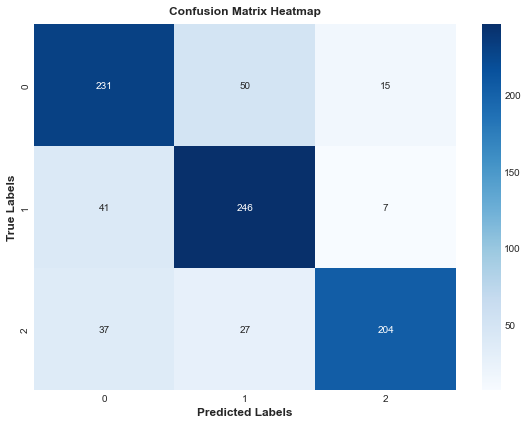

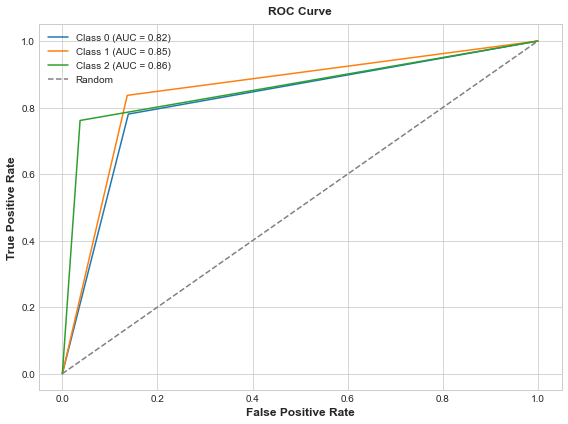

In [24]:

# ... (previous code)

# Compute and plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


# ... (previous code)

# Convert labels to one-hot encoded format
y_test_one_hot = label_binarize(all_labels, classes=[0, 1, 2])
y_pred_one_hot = label_binarize(all_preds, classes=[0, 1, 2])

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

